# Homework 5 - Part 2

In this part, we will perform sentiment analysis on every email message and aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pycountry

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

import itertools
import pickle # to easily save/load data on files

/home/bbaga/src/anaconda2/envs/py34/lib/python3.4/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In this part, we only need to get to use the emails.

In [2]:
# import the csv
df_Emails = pd.read_csv('hillary-clinton-emails/Emails.csv')

As requested, we use pycountry for the country recognition. However the lookup function is not very handy as an exception is thrown for unknow country/string (i.e. for 'french' it will throw an exception). For that reason we use the pycountry is a different manner. But first let's create a new column where will be put the countries referred in each mail.

In [3]:
df_Emails['countries'] = ""

Let's create a function that will return a list of countries given as input a text. We use pycountry to get a list of countries. We decide to use the names only because the alpha_2 was returning more false positive than meaningful results. (see belove for an example of data that we could use).
    Country(alpha_2='UG', alpha_3='UGA', name='Uganda', numeric='800', official_name='Republic of Uganda')

In [4]:
def detectCountries(text):
    text = text.lower()
    countries = []
    for c in pycountry.countries:
        if c.name.lower() in text:
            countries.append(c.name)
    return countries

In [5]:
df_Emails['countries'] = df_Emails['RawText'].apply(detectCountries)

And now we can check that the 'countries' column is indeed containing values.

In [7]:
df_Emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,countries
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,[]
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,..."
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...,[]
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,[Egypt]
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,"[Egypt, Spain, France, Israel, Lebanon, Libya,..."


It is now time to get to the real business here, and apply some sentiment analysis tool on the emails, per country.

## Method 1

The first method we experiment is by extracting the negative, positive and neutral emotion on each words ourselves and see what we get from that.

In [8]:
""" extractSentiment is a function to extract the sentiment score apply on a text.
    input: a text as string.
    output: the sums of neg, pos and neu in an array."""
def extractSentiment(text):
    token_txt = tokenize.sent_tokenize(text)

    neg=[]
    pos=[]
    neu=[]
    
    for w in token_txt:
        polarity = SentimentIntensityAnalyzer().polarity_scores(w)
        
        neg.append(polarity['neg'])
        pos.append(polarity['pos'])
        neu.append(polarity['neu'])
    return [sum(neg), sum(pos), sum(neu)]

In [10]:
# uncomment to calculate it, however we store the result as it is computationally heavy.
#df_Emails['sentiment'] = df_Emails['RawText'].apply(extractSentiment)

# we use pickle to store the result in a file.
#pickle.dump( df_Emails, open( "df_Emails.p", "wb" ) )

In [11]:
# load the dataframe
df_Emails = pickle.load( open( "df_Emails.p", "rb" ) )

In [12]:
df_Emails.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,countries,sentiments
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,[],"[2.58, 1.403, 11.017]"
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...","[10.085, 6.092999999999997, 60.825]"


As it can be seen above, the sentiments (positive, negative and neutral) are stored in one column, which is not easy to use as is, so we separate it into distinct columns.

In [13]:
x = df_Emails["sentiments"].tolist()

In [18]:
y = pd.DataFrame(x) # contains a dataframe with the 3 columns: pos, neg, neu
y.columns = ['pos', 'neg', 'neu']

In [19]:
# we concatenate the 2 dataframe
df = pd.concat([df_Emails, y], axis=1)

# ... and remove the sentiments column
del df['sentiments']

#

In [20]:
# A look at the resulting dataframe
df.head(3)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,countries,pos,neg,neu
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...,[],2.580,1.403,11.017
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...,[],2.694,1.049,12.257


From here we can already see the overall sentiment analysis over the whole set of mails.

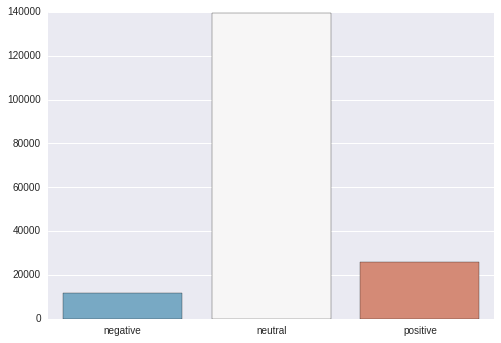

In [21]:
x = ["negative", "neutral", "positive"]
y = [df.neg.sum(), df.neu.sum(), df.pos.sum()]

sns.barplot(x, y, palette="RdBu_r")

plt.show()

Let's now calculate those neg/neu/pos scores by country. We have a list of country names in our column "countries" which we "explode" into rows. Let's see two examples to make it clear:
- countries = [], then we do not keep the row
- countries = ['France', 'Switzerland'], then we create two rows with a 'Country' row set to both values.

In [22]:
df_new = df.groupby('Id').countries.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)

In [23]:
df_new.columns = ['Id', 'Country']

In [24]:
# we merge our dataframe with 'id' and 'country' to the emails dataframe
inner_merged = pd.merge(left=df_new,right=df, left_on='Id', right_on='Id')

In [26]:
# resulting dataframe (it is to note that the mails with no country found are not here anymore)
inner_merged.head(2)

,Id,Country,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,...,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,countries,pos,neg,neu
0,2,Egypt,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825
1,2,Spain,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825


In [29]:
polarity_df = inner_merged.groupby('Country')[['pos', 'neg', 'neu']].mean()

# calculate the polarity (between 1 and -1)
polarity_df['polarity'] = polarity_df.apply(lambda x: (x['pos'] - x['neg'])/(x['pos'] + x['neg']), axis=1)

In [31]:
polarity_df = polarity_df.reset_index()

polarity_df.head()

,Country,pos,neg,neu,polarity
0,Afghanistan,8.52782,5.651329,56.930759,0.202868
1,Albania,8.73650,7.340250,79.424000,0.086849
2,Algeria,9.96355,5.103400,57.632700,0.322570
3,American Samoa,5.42750,3.435000,38.139500,0.224824
4,Andorra,3.74700,2.116500,29.387250,0.278076


Let's finally plot the polarity

In [51]:
# prepare the sorting
sorted_ = polarity_df.groupby("Country").mean().sort_values(by="polarity")

# and the color
coloring = ['B' if pol > 0 else 'R' for pol in sorted_.polarity]

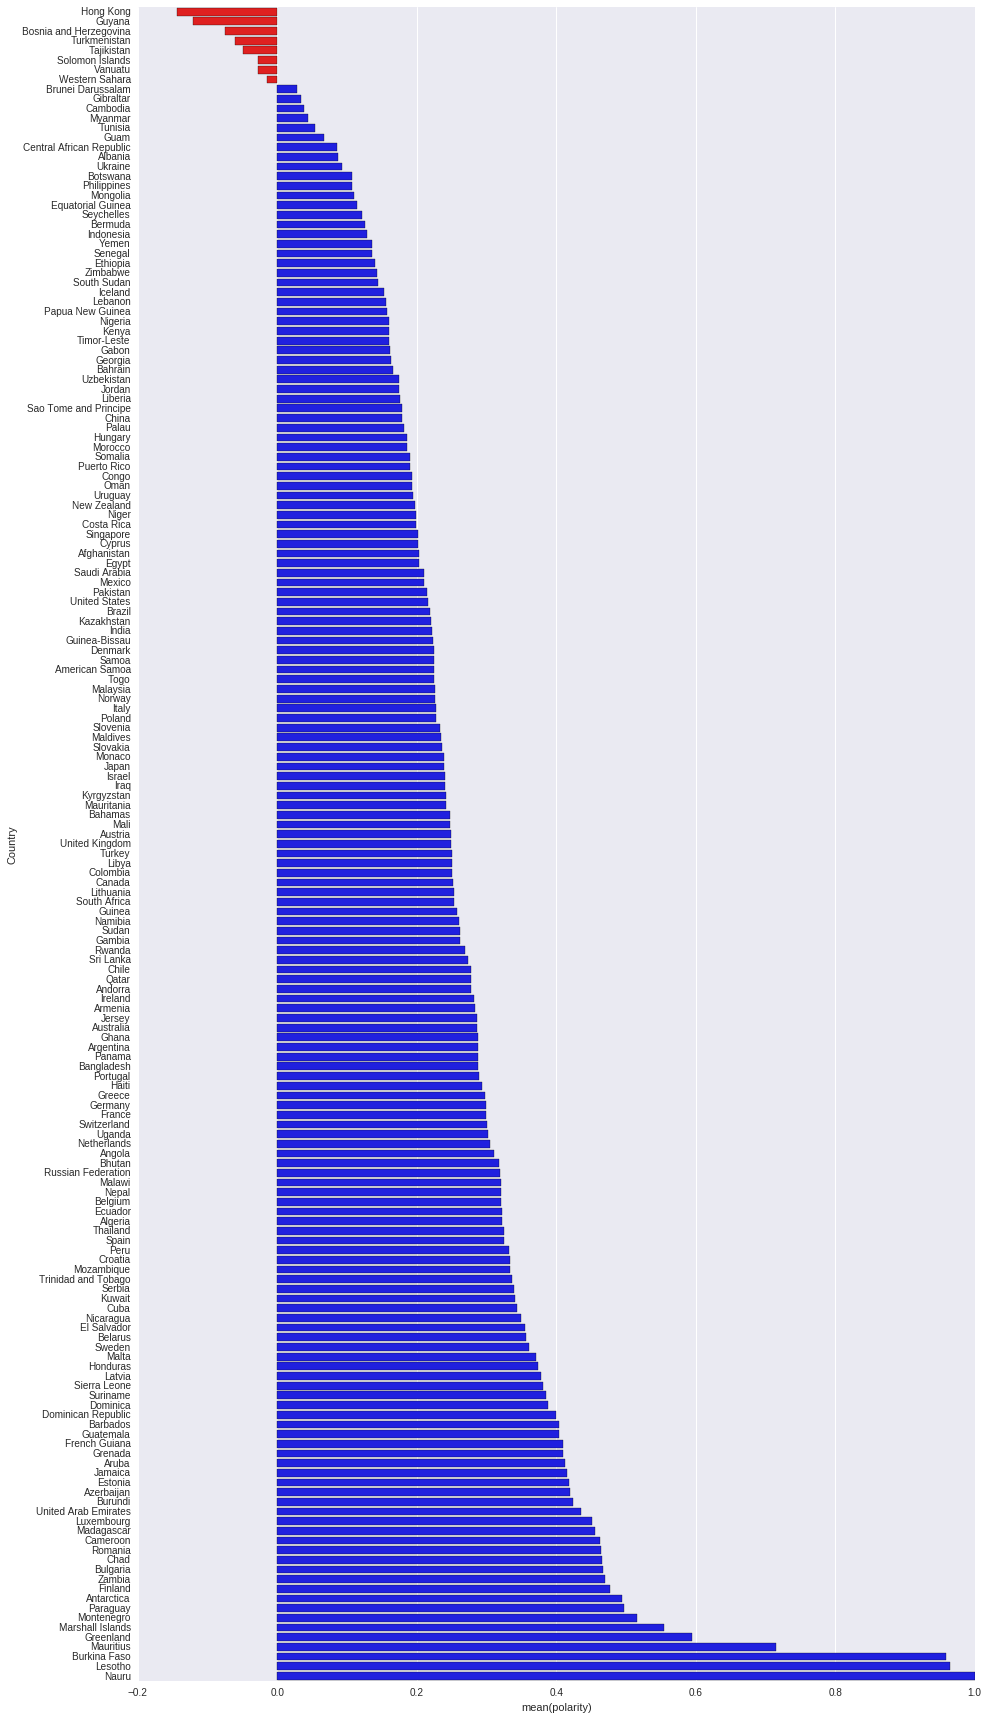

In [55]:
plt.subplots(figsize=(15,30))
sns.barplot(x="polarity", 
            y="Country", 
            data=polarity_df,
            palette = coloring,
            order=sorted_.index)
plt.show()

## Method 2

The second method is by using the sentiment analysis tool on the whole email. We can reuse the dataframe created in the method 1 with one row per country for each mail.

In [35]:
inner_merged.head()

,Id,Country,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,...,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,countries,pos,neg,neu
0,2,Egypt,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825
1,2,Spain,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825
2,2,France,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825
3,2,Israel,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825
4,2,Lebanon,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,...,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[Egypt, Spain, France, Israel, Lebanon, Libya,...",10.085,6.093,60.825


In [41]:
""" Only keep the 'compound' value extracted by the Sentiment Intensity Analyzer."""

def extractSentimentCompound(text):
    polarity = SentimentIntensityAnalyzer().polarity_scores(text)
    return polarity['compound']

In [ ]:
# too heavy, actually it never ended because we have bad computers :( After finding that result we just had to use
# perform similar commands to output the plot !

inner_merged['sentiment2'] = inner_merged['RawText'].apply(extractSentimentCompound)